In [56]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import butter, lfilter
import math
import re
from sklearn.svm import SVC
import random
from random import shuffle
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import os
from sklearn import linear_model
from sklearn import preprocessing

class Preprocessor():
    def __init__(self,data):
        self.data = data
        self.sampleData = self.getSampleData(5)
        self.filterData = self.butter_bandpass_filter(0.5,50,200)
        self.featuresData = self.get_feature(self.filterData)

    def getSampleData(self,sampleRate):
        newData = []
        for value in self.data:
            sampledData = value[:,::sampleRate]
            newData.append(sampledData)
        return newData

    def butter_bandpass(self,lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a

    def butter_bandpass_filter(self, lowcut, highcut, fs, order=5):
        b, a = self.butter_bandpass(lowcut, highcut, fs, order=order)
        newData = []
        for value in self.sampleData:
            channelList = []
            for singleChannel in value:
                y = lfilter(b, a, singleChannel)
                channelList.append(y)
            newData.append(channelList)
        return newData


    def fft(self, all_channel_data):
        fft = map(lambda x: np.fft.fft(x), all_channel_data)
        return fft

    def get_frequency(self, all_channel_data):
        """
        Get frequency from computed fft for all channels.
        Input: Channel data with dimension N x M. N denotes number of channel and M denotes number of EEG data from each channel.
        Output: Frequency band from each channel: Delta, Theta, Alpha, Beta, and Gamma.
        """
        # Length data channel
        all_channel_data = preprocessing.StandardScaler().fit_transform(all_channel_data)
        
        L = len(all_channel_data[0])
        #print(L)
        # Sampling frequency
        Fs = 200

        # Get fft data
        data_fft = self.fft(all_channel_data)

        # Compute frequency
        frequency = [ abs( x / L) for x in data_fft]
        frequency = [ x[: L // 2 + 1] * 2 for x in frequency]
 
        delta = [x[L*1 //Fs- 1: L*4 // Fs] for x in frequency]
        theta = [x[L * 4 // Fs - 1: L * 8 // Fs] for x in frequency]
        alpha = [x[L * 5 // Fs - 1: L * 13 // Fs] for x in frequency]
        beta =  [x[L * 13 // Fs - 1: L * 30 // Fs] for x in frequency]
        gamma = [x[L * 30 // Fs - 1: L * 50 // Fs] for x in frequency]

        return delta, theta, alpha, beta, gamma
    

    def differentialEntopy(self,data):

        std = np.std(data,axis=1)
        #print('std :' + str(std))
        #print('std :', std)
        de = [ 0 if x==0 else (1.0/2)*math.log(2*math.pi*2.71*x**2)  for x in std ]
        #print('de size: ' ,de)
        return de

    def get_feature(self, all_clips_data):
        
        """
        Get feature from each frequency.
        Input: Channel data with dimension N x M. N denotes number of channel and M denotes number of EEG data from each channel.
        Output: Feature (standard deviasion and mean) from all frequency bands and channels with dimesion 1 x M (number of feature).
        """

        featuesDict = []
        for all_channel_data in all_clips_data:
            
            delta, theta, alpha, beta, gamma = self.get_frequency(all_channel_data)
            
            delta = np.array(delta,dtype = float)
            theta = np.array(theta,dtype = float)
            alpha = np.array(alpha,dtype = float)
            beta = np.array(beta,dtype = float)
            gamma = np.array(beta,dtype = float)
            
            #print('gamma :', gamma)

            delta_std = np.std(delta)
            theta_std = np.std(theta)
            alpha_std = np.std(alpha)
            beta_std = np.std(beta)
            gamma_std = np.std(gamma)

            delta_m = np.mean(delta)
            theta_m = np.mean(theta)
            alpha_m = np.mean(alpha)
            beta_m = np.mean(beta)
            gamma_m = np.mean(gamma)
            
            #print(gamma_m)
            print('delta freq :', delta.shape)
            delta_de = self.differentialEntopy(delta)
            print('delta de freq :', delta_de.shape)

            theta_de = self.differentialEntopy(theta)
            alpha_de = self.differentialEntopy(alpha)
            beta_de = self.differentialEntopy(beta)
            gamma_de = self.differentialEntopy(gamma)
            
            #l = [delta_m,theta_m, alpha_m, beta_m, gamma_m, delta_std , theta_std, alpha_std, beta_std, delta_std]
            #print(gamma_de)
            feature = delta_de + theta_de + alpha_de + beta_de + gamma_de 
            #print(len(feature))
            #print(type(feature))
            #feature = np.array((feature))
            #feature = [delta_de, theta_de,  alpha_de,  beta_de, gamma_de, l
            #feature = feature.T
            #feature = []
            #feature.extend(delta_de)
            #feature.extend(theta_de)
            #feature.extend(alpha_de)
            #feature.extend(beta_de)
            #feature.extend(gamma_de)
            #feature.extend(l)
            
            #feature.append(delta_m,theta_m, alpha_m, beta_m, gamma_m, delta_std , theta_std, alpha_std, beta_std, delta_std)
            #print(len(feature))
            #featuesDict[0] = feature
            feature = np.array((feature), dtype=float)
            featuesDict.append(feature)
        return featuesDict


# In[68]:


def getLabelData():
        labels = loadmat('label.mat')['label'].ravel()
        return labels

def loadData(dataDir):
    feat = []
    orderedLabels = []
    labels = getLabelData()
    for file in os.listdir(dataDir):
        print(file)
        data = loadmat(dataDir + "/" + file)
        del data['__header__']
        del data['__globals__']
        del data['__version__']


        for clip in data.keys():
            search = re.search(r'\d+$',clip)
            if(not search == None):
                index = int(search.group())
                orderedLabels.append(labels[index-1])
                feat.append(data[clip])
        #print(len(feat))
    #feat = np.array(feat)
    return feat,orderedLabels


# In[52]:



totalFeat = []
totalLabels = []

labels = getLabelData()

dir = os.getcwd()
dataDir = dir + "/" + "data"
feat,orderedLabels = loadData(dataDir)
totalLabels.extend(orderedLabels)
totalFeat.extend(feat)
#print(len(feat)
#print(len(orderedLabels))


# In[ ]:

#print(totalFeat)



weiwei_20131130.mat


In [57]:

rawdata = totalFeat
preprocessor = Preprocessor(rawdata)
filterData = preprocessor.filterData
featuresData = preprocessor.featuresData
featuresData = np.array(featuresData, dtype = float)
#np.save('weights',featuresData)

delta freq : (62, 124)


AttributeError: 'list' object has no attribute 'shape'

In [83]:
'''
import copy
totLab = copy.deepcopy(totalLabels)
totFeat = copy.deepcopy(featuresData)
featuresData'''

In [80]:
# featuresData = np.array(preprocessor.featuresData, dtype = float)
# totalLabels = np.array(totalLabels)
# print(totalLabels)
# featuresData = featuresData[totalLabels == -1 or totalLabels == 1]
# totalLabels = totalLabels[totalLabels == -1 or totalLabels == 1]
# print(featuresData.shape)
# print(len(totalLabels))
# #print(featuresData[0])
# #featuresData = featuresData[:,-124:]
# #featuresData.shape

[]
(0, 310)
0


/home/hamsika/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  after removing the cwd from sys.path.
/home/hamsika/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  """


[[ 2.34411053 -2.57266131]
 [ 0.97167029 -3.32068184]
 [-1.57438143 -0.02058772]
 [-1.87500828 -0.18909762]
 [-2.37153462 -0.03716043]]


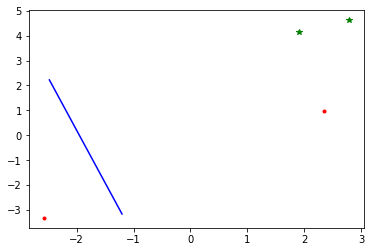

In [48]:
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt

# #print(featuresData[0])
# pca = PCA(n_components=2)
# tr = pca.fit_transform(featuresData)
# #print(tr)
# t_lab = np.array(totalLabels[:100])
# t_feat = tr[:100]
# #print(t_feat.shape)
# #plt.plot()

# #print(t_lab)
# #print(t_lab == 0)
# print(t_feat[t_lab == 0])
# plt.plot(t_feat[t_lab == 0][0],t_feat[t_lab == 0][1], 'r.')
# plt.plot(t_feat[t_lab == 1][0],t_feat[t_lab == 1][1], 'g*')
# plt.plot(t_feat[t_lab == -1][0],t_feat[t_lab == -1][1], 'b')


# plt.show()



In [87]:

'''
trainFeat, testFeat, trainLabels, testLabels = train_test_split(featuresData, totalLabels, test_size=0.2, random_state=42)

#print(trainFeat)
#print(trainLabels)
#print(testFeat)
#print(testLabels)

clf = SVC(kernel='linear')
clf.fit(trainFeat, trainLabels)
score = clf.score(testFeat,testLabels)
#score = clf.score(testFeat,testLabels)
print('svm score :' + str(score))

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(trainFeat, trainLabels) 
neigh_score = neigh.score(testFeat,testLabels)
print('neigh score :' + str(neigh_score))

logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(trainFeat, trainLabels) 
log_score = logreg.score(testFeat,testLabels)
print('Logistic : ' + str(log_score))
'''



svm score :0.6444444444444445
neigh score :0.48148148148148145
Logistic : 0.5555555555555556


In [ ]:
t_lab = labels[:100]
t_feat = featuresData[:100]

import matplotlib.pylib as plt


In [60]:
f = featuresData[0].shape

In [4]:
f = np.zeros((4,3), dtype=float)
np.save('weights',f)

In [35]:
t_feat = np.load('weights.npy')
print(t_feat.shape)
c = np.load('weights.npy')
c.shape
t2_lab = np.load('totalLabels.npy')
t_lab = np.load('totalLabels.npy')
len(t_lab)

(675, 310)


675

In [26]:
print(np.max(gammaData))
print(np.min(gammaData))

6.416462013128231
-3.8918323306352876


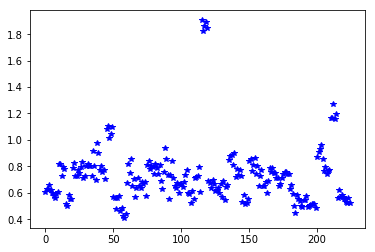

In [23]:
gammaData = c [:,-62:]
g_std = np.std(gammaData, axis = 1)
x = g_std[t_lab == 0]

plt.plot(g_std[t_lab == 0], 'b*')

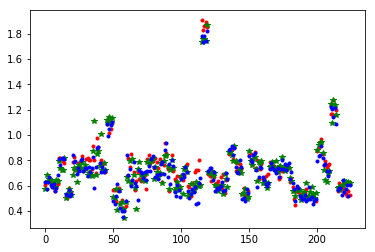

In [24]:
plt.plot(g_std[t_lab == 0], 'r.')
plt.plot(g_std[t_lab == 1], 'g*')
plt.plot(g_std[t_lab == -1], 'b.')

In [36]:

trainFeat, testFeat, trainLabels, testLabels = train_test_split(t_feat, t_lab, test_size=0.2, random_state=100)

#print(trainFeat)
#print(trainLabels)
#print(testFeat)
#print(testLabels)

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(trainFeat, trainLabels) 
neigh_score = neigh.score(testFeat,testLabels)
print('neigh score :' + str(neigh_score))

logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(trainFeat, trainLabels) 
log_score = logreg.score(testFeat,testLabels)
print('Logistic : ' + str(log_score))

svm score :0.6518518518518519
neigh score :0.45925925925925926
Logistic : 0.6


In [38]:

clf = SVC(kernel='linear')
clf.fit(trainFeat, trainLabels)
score = clf.score(testFeat,testLabels)
#score = clf.score(testFeat,testLabels)
print('svm score :' + str(score))

fu = clf.decision_function(trainFeat)
print(fu)

svm score :0.6518518518518519
[[ 1.00180164  2.08183392 -0.08363556]
 [-0.05138969  0.99095019  2.0604395 ]
 [ 0.95790326  2.16316396 -0.12106722]
 ...
 [ 1.00903181  2.06044969 -0.0694815 ]
 [ 1.12523311  2.19781883 -0.32305194]
 [ 1.00740194 -0.37215806  2.36475612]]


In [41]:
extracted = loadmat('/home/venkat/Desktop/Emotional/ExtractedFeatures/dujingcheng_20131027.mat')
extracted.keys()

dict_keys(['de_LDS5', 'dcau_LDS7', 'asm_movingAve12', 'psd_movingAve9', 'de_LDS2', 'asm_movingAve7', 'asm_movingAve5', 'de_movingAve13', 'dasm_LDS10', 'de_movingAve6', 'asm_movingAve15', 'psd_movingAve2', 'dasm_movingAve12', 'rasm_movingAve11', 'de_LDS12', 'asm_movingAve9', 'psd_movingAve13', 'rasm_LDS12', 'asm_LDS3', 'asm_movingAve11', 'de_LDS8', 'de_LDS10', 'psd_movingAve8', 'dasm_movingAve7', 'psd_LDS11', 'psd_LDS12', '__globals__', 'rasm_movingAve8', 'rasm_movingAve12', 'asm_movingAve1', 'rasm_movingAve9', 'asm_movingAve3', 'psd_movingAve5', 'rasm_LDS13', 'psd_LDS6', 'rasm_movingAve10', 'asm_movingAve2', 'rasm_movingAve5', 'dcau_movingAve15', 'dcau_LDS11', 'dcau_movingAve8', 'psd_LDS15', 'dasm_LDS4', 'psd_movingAve10', 'psd_movingAve15', 'asm_LDS9', 'dcau_movingAve5', 'asm_LDS6', 'dcau_movingAve11', 'psd_LDS14', 'rasm_LDS6', 'dasm_LDS6', 'rasm_movingAve15', 'dasm_movingAve11', 'dcau_LDS12', 'rasm_LDS8', 'psd_movingAve14', 'de_movingAve12', 'dcau_LDS2', 'psd_movingAve6', 'de_LDS7', 

In [45]:
print(extracted['de_LDS6'].shape)
print(extracted['de_movingAve6'].shape)

(62, 195, 5)
(62, 195, 5)


In [65]:
print(extracted['de_LDS7'].shape)
print(extracted['de_movingAve7'].shape)
data = extracted['de_movingAve7']

(62, 237, 5)
(62, 237, 5)


In [58]:
std = np.std(data,axis=1)
std.shape

(62, 237)

In [74]:
 def de(data):
        std = np.std(data,axis=1)
        #print('std :' + str(std))
        de = []
        #print('std :', std.shape)
        for x in std:
            for f in x:
                #print(f)
                de.append(0 if f==0 else (1.0/2)*math.log(2*math.pi*2.71*f**2))
                
        #de = [ [0 if f==0 else (1.0/2)*math.log(2*math.pi*2.71*f**2)] for f in x for x in std ]
        print('de size: ' ,len(de))
        return de
        #return de
d = de(data)
print(len(d))

de size:  310
310
